In [1]:
import glob
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from PIL import Image
import matplotlib.image as mpimg

from homo_util import hartley_normalization
from homo_util import feat2HomoConstraints
from homo_util import estHomography

from mtcnn import MTCNN
detector = MTCNN()
device = "cpu"

pad_scale=0.33
def detect_and_crop_face(path):
    image = cv2.imread(path)
    detected = detector.detect_faces(image)
    if len(detected)==1:
        x,y,w,h = detected[0]["box"]
        x=max(x,0)
        y=max(y,0)
        w=max(w,0)
        h=max(h,0)
        wpad = int(w*pad_scale)
        hpad = int(h*pad_scale)
        image = image[y-hpad:y+h+hpad, x-wpad:x+w+wpad]
    return image
    
def resize(image,outputsize):
    h, w = image.shape[:2]
    if isinstance(outputsize, int):
        if h > w:
            new_h, new_w = outputsize * h / w, outputsize
        else:
            new_h, new_w = outputsize, outputsize * w / h
    else:
        new_h, new_w = outputsize,outputsize

    new_h, new_w = int(new_h), int(new_w)

    image = cv2.resize(image, (new_w, new_h))
    return image

def centercrop(image,outputsize):
    h,w = image.shape[:2]
    new_h, new_w = outputsize,outputsize

    top = int((h - new_h)/2)
    left = int((w - new_w)/2)

    image = image[top: top + new_h,
                  left: left + new_w]
    
    return image,top,left
    
def roi_transform(path, output_size=224,crop = False):
    if crop:
        face = detect_and_crop_face(path)
    else:
        face = cv2.imread(path)
    roi = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
    roi = np.expand_dims(roi,axis = 2)
#         print(image_copy.shape)
    roi = np.concatenate((roi, roi, roi), axis=2)
    roi = roi / 255.0    
    
    roi = resize(roi,256)
#     print(roi.shape,crop)
    roi,top,left = centercrop(roi,224)
    
    roi =  roi.transpose((2, 0, 1))
    roi = np.expand_dims(roi,axis = 0)
    roi_tensor=torch.from_numpy(roi).float()

    return face,roi, roi_tensor

Using TensorFlow backend.


In [2]:
def prediction(weight_path,imagepath,crop):
    net = torch.load(weight_path, map_location=torch.device('cpu'))
    net.eval()
    face,roi_norm, roi_tensor = roi_transform(imagepath,crop = crop)
    roi_tensor=roi_tensor.to(device)
#     print(roi_tensor.shape)
    output_pts = net(roi_tensor)

    torch.squeeze(output_pts)       
    output_pts = output_pts.view(68, -1)
    predicted_key_pts = output_pts.data.cpu().numpy()
    predicted_key_pts = predicted_key_pts*50.0+100

    return face,predicted_key_pts

In [51]:
def mask2face(maskpath,image,key_pts):
    mask = cv2.imread(maskpath, cv2.IMREAD_UNCHANGED)
    mask = cv2.cvtColor(mask, cv2.COLOR_RGBA2BGRA)

    image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    image = resize(image,256)
    im,top,left= centercrop(image,224)
    key_pts = key_pts +[left,top]
    
    ind = np.argwhere(mask[:,:,3] >0)
    a=ind[np.argwhere(ind[:,0]==max(ind[:,0]))[0][0]] #down
    b=ind[np.argwhere(ind[:,0]==min(ind[:,0]))[0][0]] # top
    c=ind[np.argwhere(ind[:,1]==min(ind[:,1]))[0][0]] # left
    d=ind[np.argwhere(ind[:,1]==max(ind[:,1]))[0][0]] # right

    keypts_mask = np.array([[b[1], a[1], c[1], d[1]],
                        [b[0], a[0], c[0], d[0]], 
                        [1, 1, 1, 1]])

    keypts_face = np.array([[key_pts[28,0], key_pts[8,0], key_pts[3,0],key_pts[13,0]],
                        [key_pts[28,1], key_pts[8,1], key_pts[3,1],key_pts[13,1]], 
                        [1, 1, 1, 1]])

    feat1_nh, T1 = hartley_normalization(keypts_mask.T)
    feat2_nh, T2 = hartley_normalization(keypts_face.T)

    A_hart = feat2HomoConstraints(feat1_nh, feat2_nh)
    H_w = estHomography(A_hart)
    H_w = np.array(np.linalg.inv(T2)@H_w@(T1))

#     print(image.shape)
    im_out = cv2.warpPerspective(mask, H_w, (image.shape[1], image.shape[0]))#)

    image_copy = np.copy(image)

    vis = np.argwhere(im_out[:,:,3] > 0)

    for j in range(3):
        image_copy[vis[:,0],vis[:,1],j] = im_out[vis[:,0],vis[:,1],j]    

    plt.axis("off")
    plt.imshow(image_copy)

In [48]:
def mask2face_cool(maskpath,image,key_pts):
    mask = cv2.imread(maskpath, cv2.IMREAD_UNCHANGED)
    mask = cv2.cvtColor(mask, cv2.COLOR_RGBA2BGRA)
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    image = resize(image,256)
    im,top,left= centercrop(image,224)
    key_pts = key_pts +[left,top]
#     plt.imshow(image)
    ind = np.argwhere(mask[:,:,3] >0)
    c=ind[np.argwhere(ind[:,1]==min(ind[:,1]))[0][0]] # left
    d=ind[np.argwhere(ind[:,1]==max(ind[:,1]))[0][0]] # right


    mid=c[1]+(d[1]-c[1])//2
    b=ind[np.argwhere(ind[:,1]==mid)[0][0]]  # top
    a=ind[np.argwhere(ind[:,1]==mid)[-1][0]] #down

    keypts_mask = np.array([[b[1], a[1], c[1], d[1]],
                        [b[0], a[0], c[0], d[0]], 
                        [1, 1, 1, 1]])


    corner_gallery = np.array([[key_pts[28,0], key_pts[8,0], key_pts[2,0],key_pts[14,0]],
                [key_pts[28,1], key_pts[8,1], key_pts[2,1],key_pts[14,1]], 
                [1, 1, 1, 1]])
    
    
    feat1_nh, T1 = hartley_normalization(keypts_mask.T)
    feat2_nh, T2 = hartley_normalization(corner_gallery.T)

    A_hart = feat2HomoConstraints(feat1_nh, feat2_nh)
    H_w = estHomography(A_hart)
    H_w = np.array(np.linalg.inv(T2)@H_w@(T1))

    im_out = cv2.warpPerspective(mask, H_w, (image.shape[1], image.shape[0]))#)
#     plt.imshow(im_out)
    plt.savefig("mask.png")
    
    image_copy = np.copy(image)

    vis = np.argwhere(im_out[:,:,3] > 0)

    # for each non-transparent point, replace the original image pixel with that of the new_sunglasses
    for j in range(3):
        image_copy[vis[:,0],vis[:,1],j] = im_out[vis[:,0],vis[:,1],j]    
    
#     return image_copy
    plt.axis("off")
#     plt.savefig("mask.png")#,bbox_inches = "tight", pad_inches = 0)
    plt.imshow(image_copy)

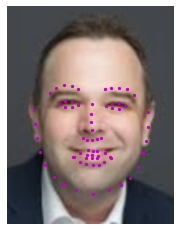

In [53]:
def face_landmark(imagepath,crop=True): ##true: detection face and crop, false: just read image. Depends on face size
    weight_path = "weights.pth"
    face,predicted_key_pts = prediction(weight_path,imagepath,crop)
    face = cv2.cvtColor(face, cv2.COLOR_BGRA2RGBA)
    face = resize(face,256)
    im,top,left = centercrop(face,224)
#     cv2.imwrite("test.jpg",face)
    plt.imshow(face)
    plt.scatter(predicted_key_pts[:, 0]+left, predicted_key_pts[:, 1]+top, s=20, marker='.', c='m')
    plt.axis("off")
    plt.show()
#     print(predicted_key_pts)
face_landmark("../test.jpeg",crop=True)

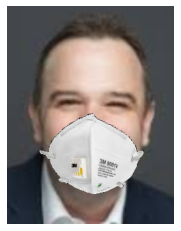

In [54]:
def face_mask(imagepath,mask_number,crop=True):
    weight_path = "weights.pth"
    face,predicted_key_pts = prediction(weight_path,imagepath,crop)
    maskpath = "mask/" + str(mask_number) +".jpg"
    if mask_number >= 6 and mask_number <= 7:
        mask2face_cool(maskpath,face, predicted_key_pts)
    elif mask_number >= 1 and mask_number <6:
        mask2face(maskpath,face, predicted_key_pts)
    else:
        print("Error: please choose a correct mask")
face_mask("../test.jpeg",3,crop=True)